# Exp: use LeNet to do classification on FasionMNIST

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.utils.data as Data

from torchvision import transforms
from torchvision.datasets import FashionMNIST

In [25]:
# load train data
train_data = FashionMNIST(
    root = "./data/FashionMNIST",
    train = True,
    transform = transforms.ToTensor(),
    download = True
)

In [26]:
# define data loader
train_loader = Data.DataLoader(
    dataset = train_data,
    batch_size = 64,
    shuffle = False,
    num_workers = 2,
)
len(train_loader) # how many batches

938

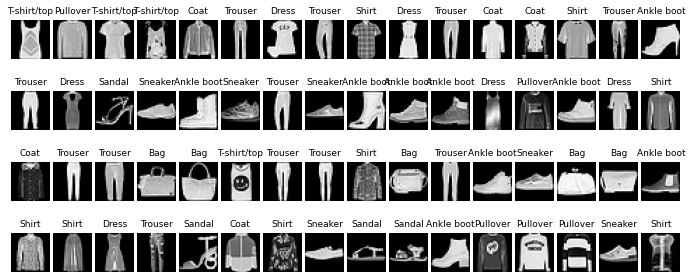

In [27]:
# plot a certain batch
for step,(b_x,b_y) in enumerate(train_loader):
    if step > 0:
        break
batch_x = b_x.squeeze().numpy()
batch_y = b_y.numpy()
class_label = train_data.classes # 10 classes

plt.figure(figsize=(12,5))
for i in range(len(batch_y)):
    plt.subplot(4,16,i+1) # 4x16 = 64
    plt.imshow(batch_x[i,:,:],cmap=plt.cm.gray)
    plt.title(class_label[batch_y[i]],size = 9)
    plt.axis("off")
    plt.subplots_adjust(wspace=0.08)

In [28]:
# load test data
test_data = FashionMNIST(
    root = "./data/FashionMNIST",
    train = False,
    download = False
)
test_data_x = test_data.data.type(torch.FloatTensor) / 255.0 # to [0,1], aka,gray image
test_data_x = torch.unsqueeze(test_data_x,dim = 1) # add 1 channel
test_data_y = test_data.targets

In [29]:
test_data_x.shape

torch.Size([10000, 1, 28, 28])

In [30]:
test_data_y.shape

torch.Size([10000])

In [31]:
# create the net
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        # conv1: 
        self.conv1 = nn.Sequential( # conv_size:16x3x3, 1x28x28 -> 16x(28+2-3+1)x(28+2-3+1) = 16x28x28
            nn.Conv2d(
                in_channels = 1,
                out_channels = 16,
                kernel_size = 3,
                stride = 1,padding = 1
            ),
            nn.ReLU(),
            nn.AvgPool2d( # pool_size:2x2, 16x28x28 -> 16x14x14
                kernel_size = 2,
                stride = 2
            )
        )
        # conv2
        self.conv2 = nn.Sequential(
            nn.Conv2d( # conv_size:32x3x3, 16x14x14 -> 32x(14-3+1)x(14-3+1) = 32x12x12
                in_channels = 16,
                out_channels = 32,
                kernel_size = 3,
                stride = 1,padding = 0
            ),
            nn.ReLU(),
            nn.AvgPool2d( # pool_size:2x2, 32x12x12 -> 32x6x6
                kernel_size = 2,
                stride = 2
            )
        )
        # classifier
        self.classifier = nn.Sequential(
            nn.Linear( # 32*6*6 -> 256
                in_features = 32*6*6,
                out_features = 256
            ),
            nn.ReLU(),
            nn.Linear( # 256 -> 128
                in_features = 256,
                out_features = 128
            ),
            nn.ReLU(),
            nn.Linear( # 128 -> 10
                in_features = 128,
                out_features = 10
            )
        )
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0),-1) # unfolding to 32*6*6
        output = self.classifier(x)
        return output

In [32]:
# print the net
convNet = ConvNet()
print(convNet)

ConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [33]:
# define train func
import copy
import time

def train(model,train_loader,train_rate,optimizer,loss_func,num_epochs=25):
    # get batch num
    batch_num = len(train_loader)
    train_batch_num = round(batch_num * train_rate)
    # best model parameters
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    # log
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    # train
    since = time.time()
    
    for epoch in range(num_epochs):
        # epoch log
        print("Epoch:{}/{}".format(epoch+1,num_epochs))
        print("-"*10)
        # train log
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0
        
        for step,(b_x,b_y) in enumerate(train_loader):
            ## two steps
            if step < train_batch_num: # train
                model.train() # train model
                output = model(b_x)
                pre_lab = torch.argmax(output,1)
                optimizer.zero_grad()
                loss = loss_func(output,b_y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()*b_x.size(0)
                train_corrects += torch.sum(pre_lab == b_y.data)
                train_num += b_x.size(0)
            else: # val
                model.eval() # val model
                output = model(b_x)
                pre_lab = torch.argmax(output,1)
                loss = loss_func(output,b_y)
                val_loss += loss.item()*b_x.size(0)
                val_corrects += torch.sum(pre_lab == b_y.data)
                val_num += b_x.size(0)
                
        ## get batch loss and acc
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item() / train_num)
        val_loss_all.append(val_loss / val_num)
        val_acc_all.append(val_corrects.double().item() / val_num)
        print("   train_loss:{:.4f} train_acc:{:.4f}".format(train_loss_all[-1],train_acc_all[-1]))
        print("   val_loss:{:.4f} val_acc:{:.4f}".format(val_loss_all[-1],val_acc_all[-1]))
        ## copy best model
        if val_acc_all[-1] > best_acc:
            best_acc = val_acc_all[-1]
            best_model = copy.deepcopy(model.state_dict())
        time_use = time.time() - since
        print("time:{:.0f}m {:.0f}s".format(time_use//60,time_use%60))
            
    # return the best model and train process
    model.load_state_dict(best_model)
    train_process = pd.DataFrame(
            data = {'epoch':range(num_epochs),
                    'train_loss_all':train_loss_all,
                   'val_loss_all':val_loss_all,
                   'train_acc_all':train_acc_all,
                   'val_acc_all':val_acc_all}
    )
    return model, train_process

In [34]:
# training
optimizer = Adam(convNet.parameters(),lr = 0.0003)
loss_func = nn.CrossEntropyLoss()
convNet,train_process = train(convNet,train_loader,0.8,optimizer,loss_func)

Epoch:1/25
----------
   train_loss:0.7859 train_acc:0.7107
   val_loss:0.5630 val_acc:0.7850
time:0m 28s
Epoch:2/25
----------
   train_loss:0.5125 train_acc:0.8082
   val_loss:0.4801 val_acc:0.8238
time:0m 56s
Epoch:3/25
----------
   train_loss:0.4426 train_acc:0.8381
   val_loss:0.4321 val_acc:0.8449
time:1m 26s
Epoch:4/25
----------
   train_loss:0.3996 train_acc:0.8550
   val_loss:0.3972 val_acc:0.8555
time:1m 54s
Epoch:5/25
----------
   train_loss:0.3697 train_acc:0.8653
   val_loss:0.3753 val_acc:0.8628
time:2m 23s
Epoch:6/25
----------
   train_loss:0.3469 train_acc:0.8730
   val_loss:0.3566 val_acc:0.8718
time:2m 51s
Epoch:7/25
----------
   train_loss:0.3286 train_acc:0.8797
   val_loss:0.3434 val_acc:0.8756
time:3m 19s
Epoch:8/25
----------
   train_loss:0.3131 train_acc:0.8860
   val_loss:0.3350 val_acc:0.8795
time:3m 47s
Epoch:9/25
----------
   train_loss:0.2994 train_acc:0.8909
   val_loss:0.3247 val_acc:0.8843
time:4m 16s
Epoch:10/25
----------
   train_loss:0.2878 tr

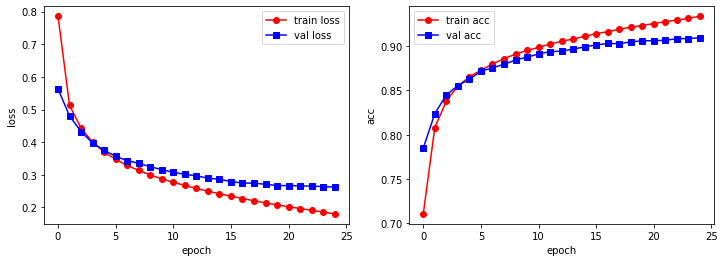

In [36]:
# plot process
plt.figure(figsize=(12,4))
## plot loss
plt.subplot(1,2,1)
plt.plot(train_process.epoch,train_process.train_loss_all,"ro-",label="train loss")
plt.plot(train_process.epoch,train_process.val_loss_all,"bs-",label="val loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
## plot acc
plt.subplot(1,2,2)
plt.plot(train_process.epoch,train_process.train_acc_all,"ro-",label="train acc")
plt.plot(train_process.epoch,train_process.val_acc_all,"bs-",label="val acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("acc")

plt.show()

In [37]:
# test
from sklearn.metrics import accuracy_score 
convNet.eval()
output = convNet(test_data_x)
pre_lab = torch.argmax(output,1)
acc = accuracy_score(test_data_y,pre_lab)
acc

0.9027

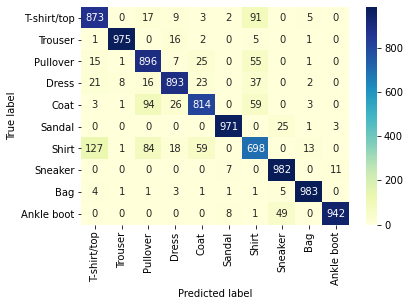

In [41]:
# get confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(test_data_y,pre_lab)
conf_mat_df = pd.DataFrame(conf_mat,index = class_label,columns = class_label)
heatmap = sns.heatmap(conf_mat_df,annot = True,fmt = "d",cmap = "YlGnBu")
## heatmap.yaxis.set_ticklables(heatmap.yaxis.get_ticklables(),rotation=0,ha='right')
## heatmap.xaxis.set_ticklables(heatmap.xaxis.get_ticklables(),rotation=45,ha='right')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()